# Creating a new fashion that has never existed in the world with GAN

## Goal of this project:
- Understand generative modeling concepts and know the difference from discriminant modeling
- Get used to image-related generative modeling applications such as Pix2Pix, CycleGAN, etc.
- Understand the meaning of the Fashion MNIST dataset
- Understand the structure and principles of generative adversarial networks (GANs)
- Apply DCGAN learning code written in TensorFlow

## Dataset
I will create a model that generates `CIFAR-10` data directly using the DCGAN model structure for FASHION-MNIST data generation.   
https://www.cs.toronto.edu/~kriz/cifar.html


## Table of Contents
1. CIFAR-10 Dataset Configuration
2. Implementing the generator model
3. Implementing the discriminator model
4. Implementing loss and optimization functions
5. Implementation of detailed training process function
6. Train the model
7. Visualize the training process

# What is GAN?


# 1. CIFAR-10 Dataset Configuration

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.4.1


The CIFAR-10 dataset is included in datasets in tf.keras, so I can just grab the dataset.

In [2]:
from tensorflow.keras.datasets import cifar10

cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()
train_x.shape

170500096/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

In [3]:
print(train_x.max())
print(train_x.min())

255
0


- Normalize the images of train_x to be used for training by -1, 1.
- Visualize the training data.
- Configure a mini-batch dataset using the from_tensor_slices() function of the tf.data.Dataset module.

In [4]:
train_x = (train_x - 127.5) /127.5 # nornalize by [-1, 1]

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

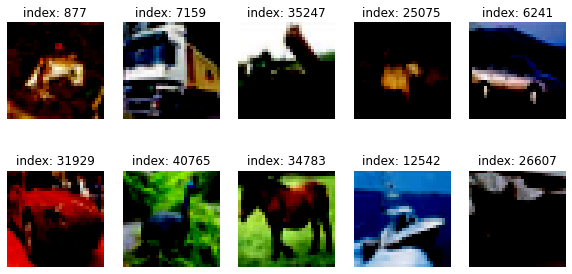

In [6]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[i].reshape(32, 32,3))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [7]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [8]:
#미니배치 학습
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 2. Implementing the generator model

In [9]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [10]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [11]:
noise = tf.random.normal([1, 100])

In [12]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

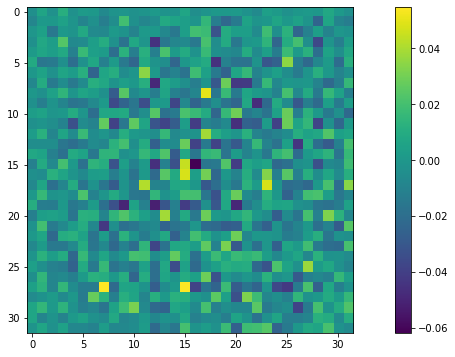

In [42]:
plt.imshow(generated_image[0, :, :, 0])
plt.colorbar()
plt.show()

# 3. Implementing the discriminator model

In [14]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.000886]], dtype=float32)>

# 4. Implementing loss and optimization functions

## Loss function
Goal of the generator and discriminator:   
- Generator: The value determined by the discriminator for the fake image, that is, the value of `D (fake_image)` approaches 1
- Discriminator: Real image discriminant value, that is, `D (real_image)` approaches 1, and fake image discriminant value, i.e. `D (fake_image)`, approaches 0


The tf.keras.losses library provides the cross entropy function to use for the loss function.

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

To calculate the loss (by `cross_entropy`), we need to use `fake_output` and `real_output`.

- `fake_output` : The value determined by inputting the fake image generated by the constructor into the delimiter, that is, D (fake_image)
- `real_output` : The value determined by inputting the existing Real Image into the delimiter, that is, D (real_image)

You can use `tf.ones_like()` and `tf.zeros_like()` to create a vector that is the same size as a specific vector and filled with values 1 or 0.

## Generator loss

Since `generator_loss` wants fake_output to be close to 1, you can calculate the cross entropy value with tf.ones_like as follows.
That is, the `cross_entropy(tf.ones_like(fake_output), fake_output)` value has a smaller value as fake_output is closer to 1 (meaning Real Image).

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Discriminator loss
Since discriminator_loss wants the real_output value to be close to 1 and the fake_output value to be close to 0, it calculates both loss values. You can compare real_output with a vector filled with ones and fake_output with a vector filled with zeros.

In [19]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

## Distriminator accuracy
It is also very important for GAN learning to calculate the accuracy of how accurately the discriminator discriminates the real output and the fake output. In particular, it is very useful to calculate and compare the two accuracies separately.

In [20]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## Optimizer

Since the generator and delimiter are separate networks that are trained separately, an optimizer must be created separately.

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

The sample will generate 16 images at a time.
Since the sample has the same noise each time to check the progress, it is necessary to create a fixed seed noise.
That is, we will create a vector of (16, 100) shape with a total of 16 100-dimensional noise.

In [22]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 5. Implementation of detailed training process function

In [ ]:
(1) Input data: A set of images that will act as a Real Image is received as input.
(2) Generator input noise: The generator generates noise for generating FAKE IMAGE as much as BATCH_SIZE, which is the same size as a set of images.
(3) tf.GradientTape() opens the with statement to automatically calculate the gradient for weight update
(4) Generate generated_images: Generate generated_images after the generator receives noise input
(5) Discriminator discrimination: After the discriminator receives images that are Real Images and generated_images that are fake images, respectively, output real_output and fake_output
(6) Loss calculation: Calculate the loss of each generator and discriminator with fake_output and real_output
(7) Accuracy calculation: Calculate the accuracy of discriminator with fake_output and real_output
(8) Gradient calculation: Automatically calculate gradient using gen_tape and disc_tape
(9) Model training: update the weight by inputting the calculated gradient into the optimizer
(10) Return value: Returns the loss and accuracy calculated in this step

In [23]:
@tf.function
def train_step(images): # (1) input data
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) generator input noise

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() open
        generated_images = generator(noise, training=True)  #(4) generated_images 

        #(5) discriminator 
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) Model Train
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) return

In [43]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0])
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

## Visualize Accuracy 

In [36]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

Checkpoint saves the optimizer, constructor, and delimiter. So it stores the model weights learned by the generator and delimiter. Like a checkpoint in a game.

We will use a directory called training_checkpoints to store our checkpoint models.

In [37]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# 6. Train the model

In [38]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [39]:
save_every = 5
EPOCHS = 50

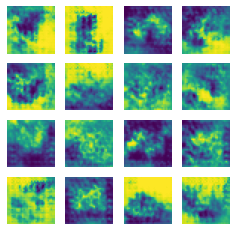

Time for training : 1521 sec


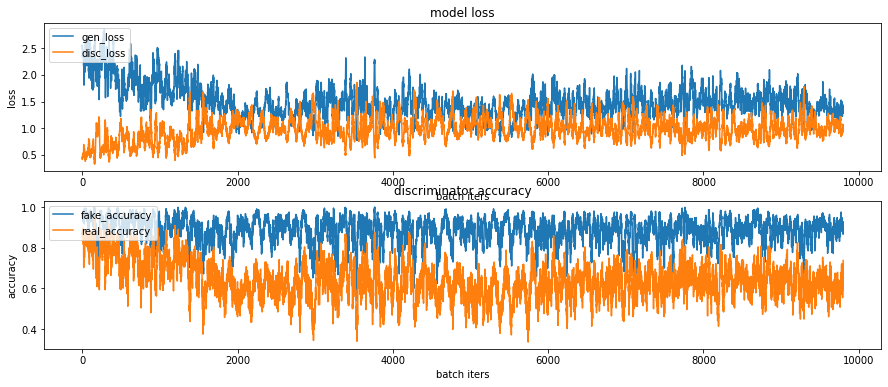

CPU times: user 25min 17s, sys: 15.7 s, total: 25min 33s
Wall time: 25min 22s


In [44]:
%%time
train(train_dataset, EPOCHS, save_every)

# 7. Visualize the training process

In [45]:

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1326278 Sep  2 04:12 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


We can merge the sammple images we created and create a .gif file.


[![fashion_mnist_dcgan.gif](https://s9.gifyu.com/images/fashion_mnist_dcgan.gif)](https://gifyu.com/image/GXV0)


Okay, I think the images is doing something...

Let's also check whether the loaded model can generates images just like cifar-10.

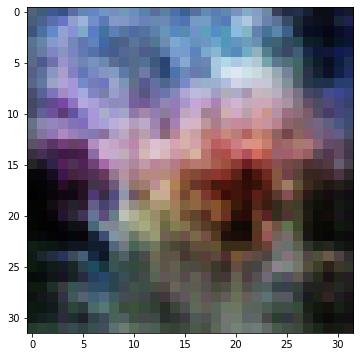

In [46]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator


noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show() 

I think..! It looks like some kind of a fish..   
You'll find it if you look with your heart's eye

# Conclusion
## What I've learned
- Understand generative modeling concepts and know the difference from discriminant modeling
- Get used to image-related generative modeling applications such as Pix2Pix, CycleGAN, etc.
- Understand the meaning of the Fashion MNIST dataset
- Understand the structure and principles of generative adversarial networks (GANs)
- Apply DCGAN learning code written in TensorFlow

## Challenges I've Faced
- The model took really long time with input with images
- I had to increase the epochs to more then 50.
- The generated image is hard to recognize
- It was hard to make the model converge the fake accuracy to 0.5

